In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime

%matplotlib inline
#plt.style.use('ggplot')

# Comparar historico distintas estrategias

In [2]:
# Descarga datos historicos multifondos AFP Cuprum
url_data = 'https://rawgit.com/collabmarket/data_afp/master/data/VC-CUPRUM.csv'
afp_name = url_data.split('-')[-1].split('.')[0] # Nombre de la afp
karg_csv = dict(delimiter=';', decimal=',', index_col=0, parse_dates=True)
afp = pd.read_csv(url_data, **karg_csv) # Crea DataFrame con los datos
afp.dropna(inplace=True) # Elimina filas sin datos de para todos los fondos

## Felices y Forrados 

Fuente: https://www.felicesyforrados.cl/resultados/

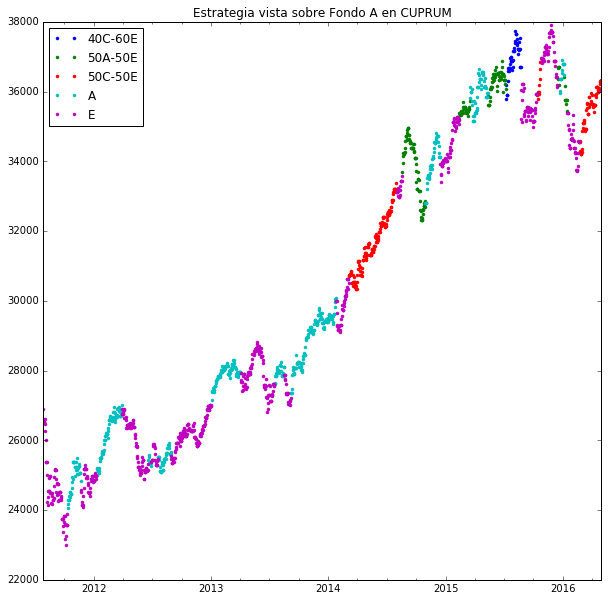

In [3]:
karg_csv = dict(delimiter=';', decimal=',', index_col='DATE', parse_dates=True)
df = pd.read_csv('data/estrategias.csv', **karg_csv)
df.resample('D').ffill()
fyf = df.resample('D').ffill()
df = pd.concat([afp,fyf], axis=1)
gb = df[['A','B','C','E','FyF']].groupby('FyF')
fig, ax = plt.subplots()
gb.A.plot(style='.', title='Estrategia vista sobre Fondo A en %s'%(afp_name), figsize=(10, 10),ax=ax)
plt.legend(loc=2)

## Estrategia base propuesta

Es la estrategia más simple de cambio de fondo A-E, cualquier estrategia más complicada debería entregar mejor rentabilidad, en caso contrario está haciendo overfitting o es inconsistente.
Fuente https://github.com/collabmarket/algorithms_afp

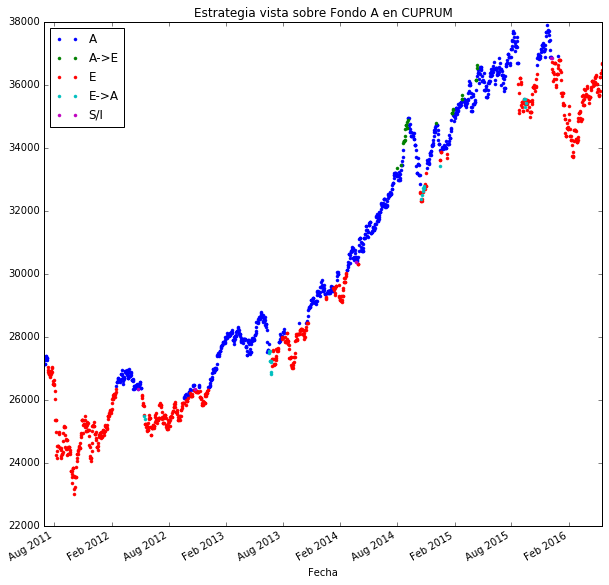

In [4]:
# Delta es Valor relativo (diferencia o resta) entre valores cuota de A y E
afp['delta'] = afp.A - afp.E
# Parametros: ['median',365] (elejimos mediana movil 365 dias)
afp['zero'] = afp.delta.rolling(window=365,center=False).median()
# Criterios de Entrada a renta variable
# Parametros: ['quantile',0.1,365] (elejimos cuantil 10% ventana 365 dias)
afp['entra'] = afp.delta.rolling(window=365,center=False).quantile(quantile=0.1)
# Criterios de Salida a renta fija
# Parametros: ['quantile',0.9,365] (elejimos cuantil 90% ventana 365 dias)
afp['sale'] = afp.delta.rolling(window=365,center=False).quantile(quantile=0.9)
# Criterio rentabilidad de corto plazo (15 dias)
afp['rate'] = afp.delta.pct_change(15)
# Solo a partir de 2011-07-01
afp = afp['2011-07-01':]
# Caso base se marca como desconocido, Sin Informacion (S/I)
afp['estrategia'] = 'S/I'
# Segnales de largo plazo 
afp.loc[afp.delta < afp.zero,'estrategia'] = 'E'
afp.loc[afp.delta > afp.zero,'estrategia'] = 'A'
# Segnales de mediano plazo
afp.loc[(afp.delta > afp.entra) & (afp.delta < afp.zero) & (afp.rate > 1),'estrategia'] = 'E->A'
afp.loc[(afp.delta > afp.sale) & (afp.rate < -1),'estrategia'] = 'A->E'
# Grafico estrategia base
gb = afp[['A','B','C','E','estrategia']].groupby('estrategia')
fig, ax = plt.subplots()
gb.A.plot(style='.', title='Estrategia vista sobre Fondo A en %s'%(afp_name), figsize=(10, 10), ax=ax)
plt.legend(loc=2)

In [5]:
#%qtconsole